# Overlay an AIA image on a LASCO C2 coronagraph

- https://docs.sunpy.org/en/stable/generated/gallery/plotting/lasco_overlay.html

This example shows the steps needed to overlay the disc and off-limb
components of an AIA image within the masked occulter of a LASCO C2 image.

In [ ]:
from datetime import datetime

import hvpy
import matplotlib.pyplot as plt
from hvpy.datasource import DataSource

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
from sunpy.coordinates import SphericalScreen
from sunpy.map import Map
from sunpy.util.config import get_and_create_download_dir

First, we will acquire a calibrated LASCO C2 image from Helioviewer and
create a map. hvpy uses the standard datetime instead of astropy.time.

In [ ]:
lasco_jp2_file = hvpy.save_file(hvpy.getJP2Image(datetime(2011, 6, 7, 6, 34),
                                                 DataSource.LASCO_C2.value),
                                filename=get_and_create_download_dir() + "/LASCO_C2.jp2", overwrite=True)
lasco_map = Map(lasco_jp2_file)
aia_map = Map(sunpy.data.sample.AIA_171_IMAGE)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


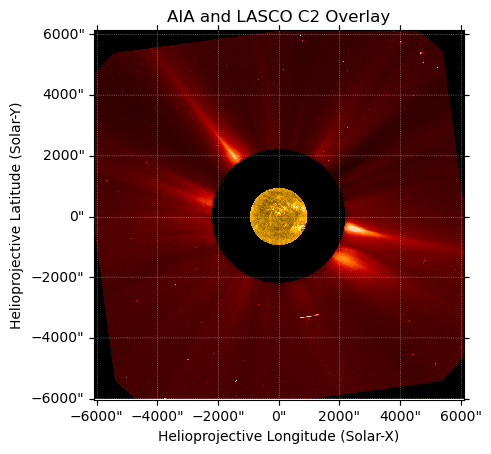

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
aia_map.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)
ax.set_title("AIA and LASCO C2 Overlay")

plt.show()

Note that off-disk AIA data are not retained by default because an
additional assumption is required to define the location of the AIA
emission in 3D space. We can use `sunpy.coordinates.SphericalScreen` to
retain the off-disk AIA data.

In [ ]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
# We use `sunpy.coordinates.SphericalScreen` to ensure that the off limb AIA pixels
# are reprojected. Otherwise it will only be the on disk pixels that are reprojected.
with SphericalScreen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

Finally, we plot the images by layering the AIA image on top of the LASCO C2
image.

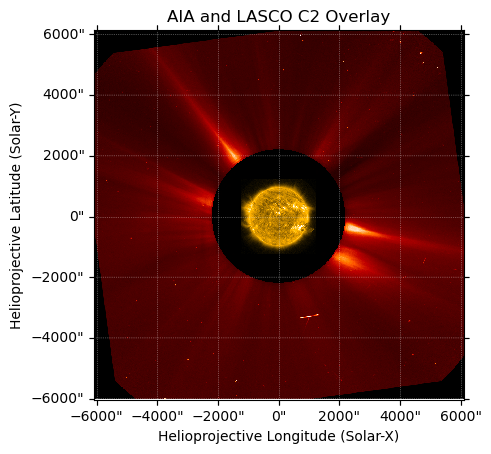

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
aia_reprojected.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)
ax.set_title("AIA and LASCO C2 Overlay")

plt.show()